# EDA — KITTI-MOTS Dataset

**Split (from seqmap files):**
- **Train** (12 seqs): 0000, 0001, 0003, 0004, 0005, 0009, 0011, 0012, 0015, 0017, 0019, 0020
- **Val**   (9 seqs):  0002, 0006, 0007, 0008, 0010, 0013, 0014, 0016, 0018

Annotations are in `instances_txt/`, images in `training/image_02/`.


In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
from pycocotools import mask as mask_utils

# ── Paths ────────────────────────────────────────────────────────────────────
BASE_DIR          = "/home/mcv/datasets/C5/KITTI-MOTS"
IMAGE_DIR         = os.path.join(BASE_DIR, "training", "image_02")
INSTANCES_TXT_DIR = os.path.join(BASE_DIR, "instances_txt")

# Sequences from seqmap files
TRAIN_SEQS = [0, 1, 3, 4, 5, 9, 11, 12, 15, 17, 19, 20]
VAL_SEQS   = [2, 6, 7, 8, 10, 13, 14, 16, 18]

KITTI_MOTS_CLASSES = {1: "Car", 2: "Pedestrian"}


## Image counts — total and per sequence

In [2]:
def count_images(seq_list):
    """Return {seq_str: num_images} for a list of sequence IDs."""
    counts = {}
    for seq_id in seq_list:
        seq_str = f"{seq_id:04d}"
        seq_path = os.path.join(IMAGE_DIR, seq_str)
        n = len(glob.glob(os.path.join(seq_path, "*.png")))
        counts[seq_str] = n
    return counts

train_img_counts = count_images(TRAIN_SEQS)
val_img_counts   = count_images(VAL_SEQS)

total_train = sum(train_img_counts.values())
total_val   = sum(val_img_counts.values())

print(f"{'Split':<8} {'Sequences':>10} {'Total images':>14}")
print("-" * 36)
print(f"{'Train':<8} {len(train_img_counts):>10} {total_train:>14}")
print(f"{'Val':<8} {len(val_img_counts):>10} {total_val:>14}")
print(f"{'TOTAL':<8} {len(train_img_counts)+len(val_img_counts):>10} {total_train+total_val:>14}")

print("\n── Images per sequence ──────────────────")
print(f"\n{'Seq':<8} {'Split':<8} {'Images':>8}")
print("-" * 28)
for seq_str, n in train_img_counts.items():
    print(f"{seq_str:<8} {'train':<8} {n:>8}")
for seq_str, n in val_img_counts.items():
    print(f"{seq_str:<8} {'val':<8} {n:>8}")


Split     Sequences   Total images
------------------------------------
Train            12           5027
Val               9           2981
TOTAL            21           8008

── Images per sequence ──────────────────

Seq      Split      Images
----------------------------
0000     train         154
0001     train         447
0003     train         144
0004     train         314
0005     train         297
0009     train         803
0011     train         373
0012     train          78
0015     train         376
0017     train         145
0019     train        1059
0020     train         837
0002     val           233
0006     val           270
0007     val           800
0008     val           390
0010     val           294
0013     val           340
0014     val           106
0016     val           209
0018     val           339


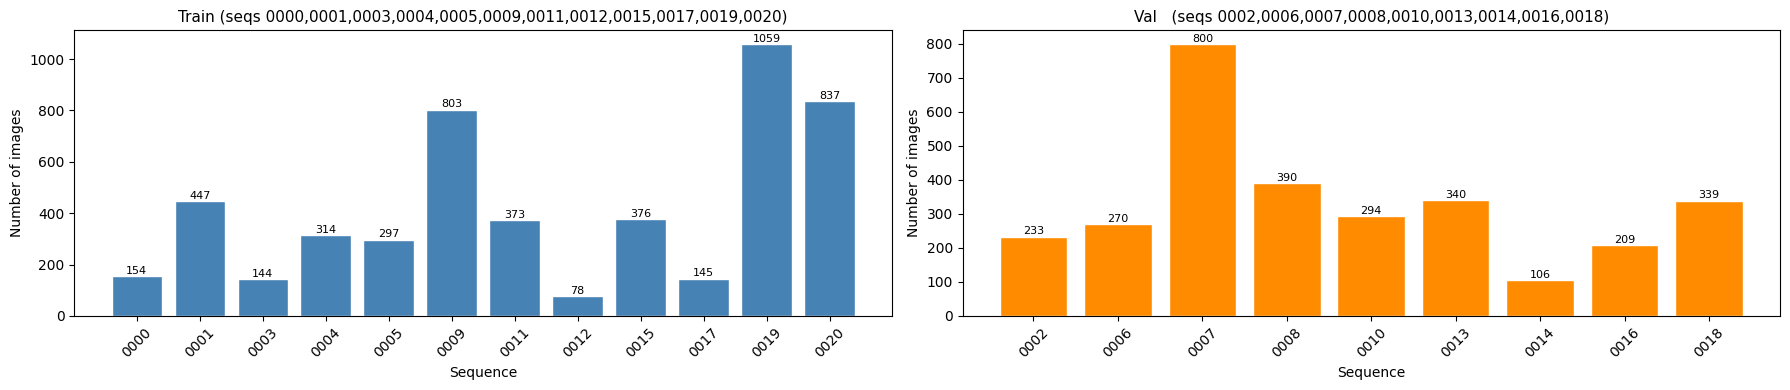

In [3]:
# Bar chart: images per sequence
fig, axes = plt.subplots(1, 2, figsize=(18, 4), sharey=False)

for ax, counts, title, color in [
    (axes[0], train_img_counts, "Train (seqs 0000,0001,0003,0004,0005,0009,0011,0012,0015,0017,0019,0020)", "steelblue"),
    (axes[1], val_img_counts,   "Val   (seqs 0002,0006,0007,0008,0010,0013,0014,0016,0018)",               "darkorange"),
]:
    ax.bar(counts.keys(), counts.values(), color=color, edgecolor="white")
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Number of images")
    ax.tick_params(axis="x", rotation=45)
    for bar, v in zip(ax.patches, counts.values()):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
                str(v), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


## GT detections — count per class, per sequence and per split

In [4]:
def load_detection_counts(seq_list):
    """
    Parse instances_txt annotations and return per-sequence detection counts.
    Format: frame_id  object_id  class_id  height  width  rle
    Returns: {seq_str: {class_name: count}}
    """
    seq_counts = {}
    for seq_id in seq_list:
        seq_str  = f"{seq_id:04d}"
        ann_file = os.path.join(INSTANCES_TXT_DIR, f"{seq_str}.txt")
        counts   = defaultdict(int)

        if not os.path.exists(ann_file):
            seq_counts[seq_str] = counts
            continue

        with open(ann_file) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 6:
                    continue
                class_id = int(parts[2])
                if class_id in KITTI_MOTS_CLASSES:
                    counts[KITTI_MOTS_CLASSES[class_id]] += 1

        seq_counts[seq_str] = counts
    return seq_counts

train_det_counts = load_detection_counts(TRAIN_SEQS)
val_det_counts   = load_detection_counts(VAL_SEQS)

# Summary table
print(f"\n{'Seq':<8} {'Split':<8} {'Car':>8} {'Pedestrian':>12} {'Total':>8}")
print("-" * 48)

def print_split(det_counts, split_name):
    total_car, total_ped = 0, 0
    for seq_str, counts in det_counts.items():
        car = counts.get("Car", 0)
        ped = counts.get("Pedestrian", 0)
        total_car += car
        total_ped += ped
        print(f"{seq_str:<8} {split_name:<8} {car:>8} {ped:>12} {car+ped:>8}")
    print(f"{'TOTAL':<8} {split_name:<8} {total_car:>8} {total_ped:>12} {total_car+total_ped:>8}")
    return total_car, total_ped

tc, tp = print_split(train_det_counts, "train")
print()
vc, vp = print_split(val_det_counts, "val")
print("-" * 48)
print(f"{'ALL':<8} {'both':<8} {tc+vc:>8} {tp+vp:>12} {tc+vc+tp+vp:>8}")



Seq      Split         Car   Pedestrian    Total
------------------------------------------------
0000     train         243           21      264
0001     train        2728          108     2836
0003     train         363            0      363
0004     train         817           64      881
0005     train        1227            0     1227
0009     train        2831           29     2860
0011     train        3349          166     3515
0012     train         140           64      204
0015     train         888          725     1613
0017     train           0          778      778
0019     train         929         6113     7042
0020     train        5316            0     5316
TOTAL    train       18831         8068    26899

0002     val           903          180     1083
0006     val           537            0      537
0007     val          2258           67     2325
0008     val          1042            0     1042
0010     val           602           55      657
0013     val      

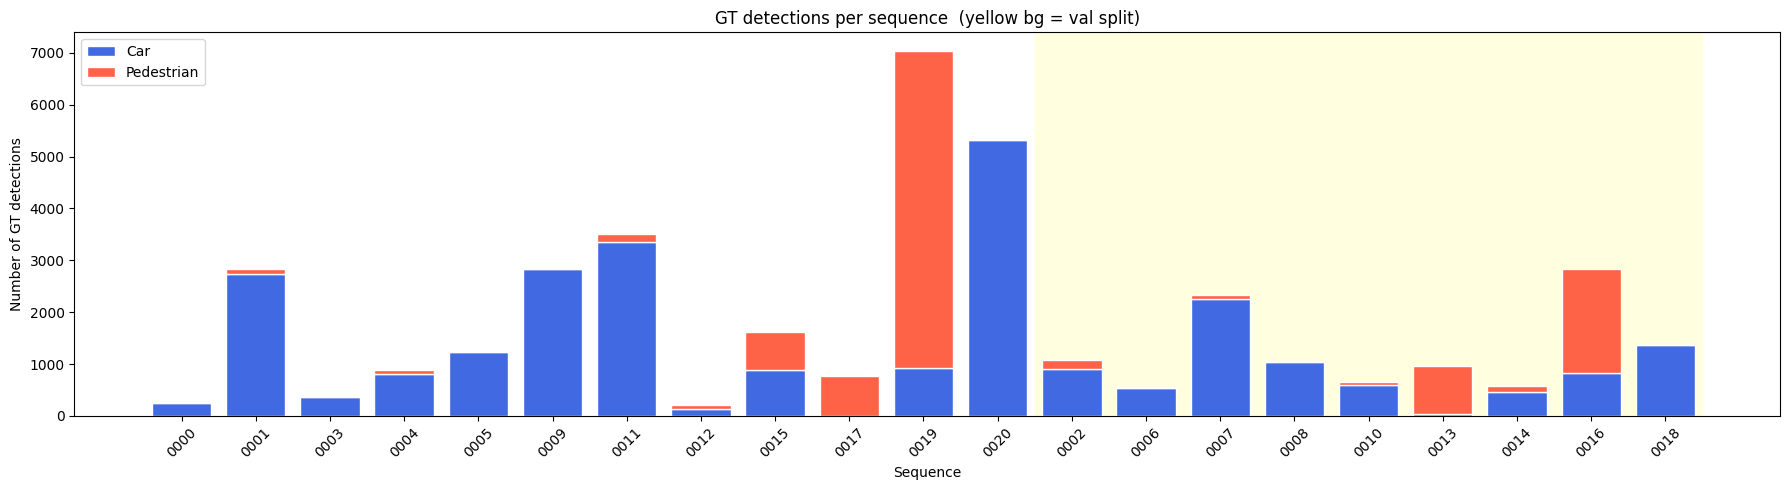

In [5]:
# Stacked bar: detections per sequence
all_counts = {**train_det_counts, **val_det_counts}
seqs   = list(all_counts.keys())
cars   = [all_counts[s].get("Car", 0) for s in seqs]
peds   = [all_counts[s].get("Pedestrian", 0) for s in seqs]

x = np.arange(len(seqs))
fig, ax = plt.subplots(figsize=(18, 5))
b1 = ax.bar(x, cars, label="Car",        color="royalblue",  edgecolor="white")
b2 = ax.bar(x, peds, label="Pedestrian", color="tomato",     edgecolor="white", bottom=cars)

# Shade val sequences differently
for i in range(len(train_det_counts), len(seqs)):
    ax.axvspan(i - 0.5, i + 0.5, color="lightyellow", zorder=0)

ax.set_xticks(x)
ax.set_xticklabels(seqs, rotation=45)
ax.set_xlabel("Sequence")
ax.set_ylabel("Number of GT detections")
ax.set_title("GT detections per sequence  (yellow bg = val split)")
ax.legend()
plt.tight_layout()
plt.show()


## Example images with GT bounding boxes

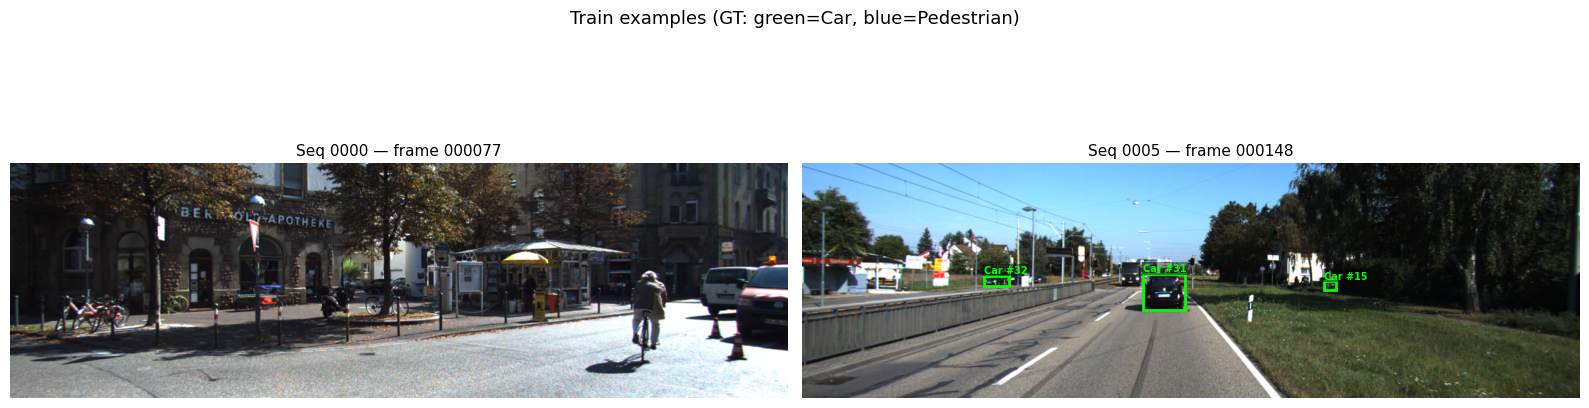

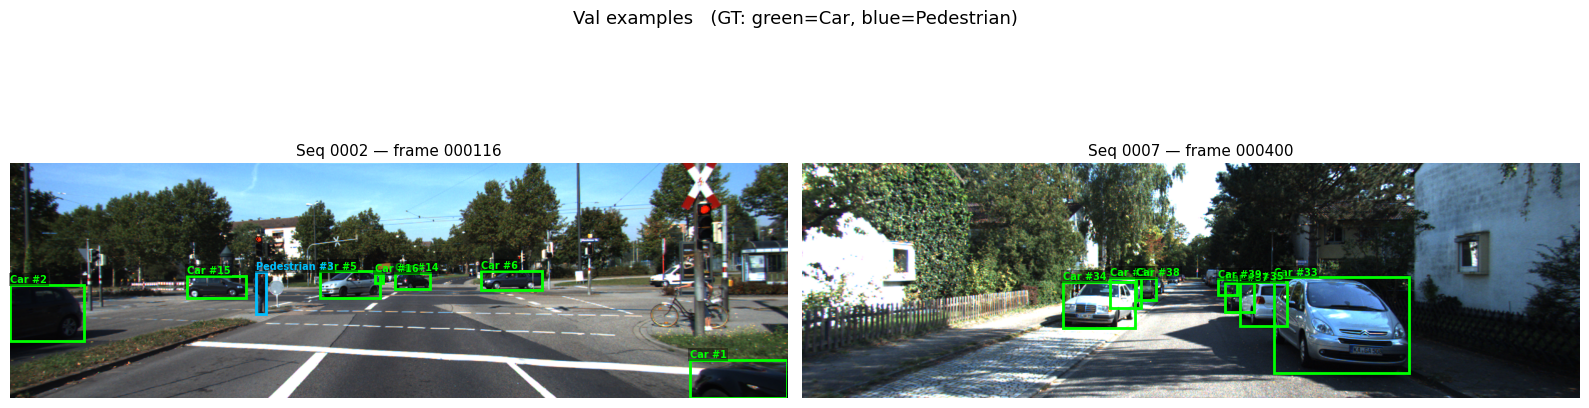

In [6]:
def get_class_and_instance(object_id):
    return object_id // 1000, object_id % 1000

def decode_rle_to_bbox(rle_str, height, width):
    rle = {"counts": rle_str.encode(), "size": [height, width]}
    binary_mask = mask_utils.decode(rle)
    occupied_rows = np.any(binary_mask, axis=1)
    occupied_cols = np.any(binary_mask, axis=0)
    if not occupied_rows.any():
        return None
    y1, y2 = np.where(occupied_rows)[0][[0, -1]]
    x1, x2 = np.where(occupied_cols)[0][[0, -1]]
    return int(x1), int(y1), int(x2), int(y2)

def load_frame_annotations(seq_str, frame_id):
    """Return list of (class_id, instance_id, bbox) for a specific frame."""
    ann_file = os.path.join(INSTANCES_TXT_DIR, f"{seq_str}.txt")
    anns = []
    if not os.path.exists(ann_file):
        return anns
    with open(ann_file) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 6:
                continue
            if int(parts[0]) != frame_id:
                continue
            object_id = int(parts[1])
            class_id  = int(parts[2])
            height    = int(parts[3])
            width     = int(parts[4])
            rle_str   = parts[5]
            if class_id not in KITTI_MOTS_CLASSES:
                continue
            _, instance_id = get_class_and_instance(object_id)
            bbox = decode_rle_to_bbox(rle_str, height, width)
            if bbox:
                anns.append((class_id, instance_id, bbox))
    return anns

def show_example_frames(examples, title):
    """
    examples: list of (seq_str, frame_id)
    """
    fig, axes = plt.subplots(1, len(examples), figsize=(8 * len(examples), 5))
    if len(examples) == 1:
        axes = [axes]
    GT_COLORS = {1: "lime", 2: "deepskyblue"}

    for ax, (seq_str, frame_id) in zip(axes, examples):
        img_path = os.path.join(IMAGE_DIR, seq_str, f"{frame_id:06d}.png")
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title(f"Seq {seq_str} — frame {frame_id:06d}", fontsize=11)
        ax.axis("off")

        for class_id, instance_id, (x1, y1, x2, y2) in load_frame_annotations(seq_str, frame_id):
            color = GT_COLORS[class_id]
            rect  = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       linewidth=2, edgecolor=color, facecolor="none")
            ax.add_patch(rect)
            ax.text(x1, max(y1 - 4, 0), f"{KITTI_MOTS_CLASSES[class_id]} #{instance_id}",
                    color=color, fontsize=7, fontweight="bold",
                    bbox=dict(facecolor="black", alpha=0.4, pad=1, edgecolor="none"))

    fig.suptitle(title, fontsize=13, y=1.01)
    plt.tight_layout()
    plt.show()

# Pick 2 train examples and 2 val examples (middle frame of the sequence)
def pick_example(seq_str):
    imgs = sorted(glob.glob(os.path.join(IMAGE_DIR, seq_str, "*.png")))
    mid  = len(imgs) // 2
    return seq_str, int(os.path.splitext(os.path.basename(imgs[mid]))[0])

train_examples = [pick_example("0000"), pick_example("0005")]
val_examples   = [pick_example("0002"), pick_example("0007")]

show_example_frames(train_examples, "Train examples (GT: green=Car, blue=Pedestrian)")
show_example_frames(val_examples,   "Val examples   (GT: green=Car, blue=Pedestrian)")
